 # Airport's ATC could have handled wartime air traffic using DQN.

**STEP 1: Install Required Libraries**

In [ ]:
!pip install gym numpy matplotlib stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

**create an environment AirportEnv**

In [ ]:
import gym
from gym import spaces
import numpy as np

class AirportEnv(gym.Env):
    def __init__(self, wartime=False):
        super(AirportEnv, self).__init__()

        # Observation space: [incoming flights, available gates, runway occupancy, priority]
        self.observation_space = spaces.Box(low=0, high=100, shape=(4,), dtype=np.int32)
        self.action_space = spaces.Discrete(4)  # 0: Gate A, 1: Gate B, 2: Delay, 3: Reroute

        self.max_gates = 10
        self.max_runways = 3
        self.wartime = wartime
        self.reset()

    def reset(self):
        self.incoming_flights = np.random.randint(10, 40) if not self.wartime else np.random.randint(30, 60)
        self.available_gates = self.max_gates
        self.runway_occupancy = np.random.randint(0, self.max_runways)
        self.flight_priority = np.random.choice([0, 1], p=[0.7, 0.3])  # 0: Civil, 1: Military
        self.time = 0
        self.total_reward = 0
        self.total_flights_handled = 0
        self.done = False
        return np.array([self.incoming_flights, self.available_gates, self.runway_occupancy, self.flight_priority])

    def step(self, action):
        reward = 0
        handled = False

        if action in [0, 1]:  # Assign gate
            if self.available_gates > 0:
                self.available_gates -= 1
                self.incoming_flights = max(0, self.incoming_flights - 1)
                reward += 2 + self.flight_priority * 2  # Prioritize military
                handled = True
            else:
                reward -= 5  # No gate available
        elif action == 2:  # Delay
            reward -= 1
        elif action == 3:  # Reroute
            self.incoming_flights = max(0, self.incoming_flights - 1)
            reward -= 2
            handled = True

        self.time += 1
        self.total_reward += reward
        if handled:
            self.total_flights_handled += 1

        self.done = self.time >= 20 or self.incoming_flights == 0

        # Update priority
        self.flight_priority = np.random.choice([0, 1], p=[0.7, 0.3])
        obs = np.array([self.incoming_flights, self.available_gates, self.runway_occupancy, self.flight_priority])
        return obs, reward, self.done, {}

    def render(self, mode="human"):
        print(f"Time: {self.time} | Flights: {self.incoming_flights} | Gates: {self.available_gates} | Runway: {self.runway_occupancy} | Priority: {'Military' if self.flight_priority else 'Civil'}")

# Naive policy for comparison
def run_naive_policy(env, episodes=10):
    rewards = []
    for ep in range(episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = 0  # Always choose Gate A
            obs, reward, done, _ = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
        print(f"Naive Episode {ep+1}: Reward = {total_reward}")
    return rewards


In [ ]:
!pip install shimmy>=2.0

In [ ]:
!pip install gym numpy matplotlib stable-baselines3 shimmy>=2.0

**Trained DQN model for 50000 timesteps**

In [ ]:
import gym
import numpy as np
from stable_baselines3 import DQN

env = AirportEnv()

model = DQN('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=50000)
model.save("airpot_dqn_agent")

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.294    |
|    n_updates        | 5940     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.3     |
|    ep_rew_mean      | 15.5     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1224     |
|    fps              | 646      |
|    time_elapsed     | 37       |
|    total_timesteps  | 23944    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.235    |
|    n_updates        | 5960     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.3     |
|    ep_rew_mean      | 15.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1228     |
|   

In [ ]:
# Evaluation function for deeper metrics
def evaluate_agent(model, env, episodes=100):
  episode_rewards = []
  flight_efficiencies = []
  for ep in range(episodes):
    obs = env.reset()
    done = False
    total_reward = 0
    steps = 0
    while not done:
      action, _ = model.predict(obs)
      obs, reward, done, _ = env.step(action)
      total_reward += reward
      steps += 1
    episode_rewards.append(total_reward)
    efficiency = env.total_flights_handled / steps if steps else 0
    flight_efficiencies.append(efficiency)
    print(f"Agent Episode {ep+1}: Reward = {total_reward}, Flights handled = {env.total_flights_handled}, Efficiency = {efficiency:.2f}")
  return episode_rewards, flight_efficiencies

In [ ]:
obs = env.reset()
done = False
total_reward = 0

while not done:
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    total_reward += reward

print(f"Total reward collected: {total_reward}")

Time: 1 | Flights: 12 | Gates: 9 | Runway: 0 | Priority: Civil
Time: 2 | Flights: 11 | Gates: 8 | Runway: 0 | Priority: Civil
Time: 3 | Flights: 10 | Gates: 7 | Runway: 0 | Priority: Civil
Time: 4 | Flights: 9 | Gates: 6 | Runway: 0 | Priority: Civil
Time: 5 | Flights: 8 | Gates: 6 | Runway: 0 | Priority: Military
Time: 6 | Flights: 7 | Gates: 5 | Runway: 0 | Priority: Military
Time: 7 | Flights: 6 | Gates: 4 | Runway: 0 | Priority: Civil
Time: 8 | Flights: 5 | Gates: 3 | Runway: 0 | Priority: Civil
Time: 9 | Flights: 4 | Gates: 2 | Runway: 0 | Priority: Military
Time: 10 | Flights: 3 | Gates: 1 | Runway: 0 | Priority: Military
Time: 11 | Flights: 2 | Gates: 0 | Runway: 0 | Priority: Civil
Time: 12 | Flights: 2 | Gates: 0 | Runway: 0 | Priority: Civil
Time: 13 | Flights: 2 | Gates: 0 | Runway: 0 | Priority: Civil
Time: 14 | Flights: 2 | Gates: 0 | Runway: 0 | Priority: Civil
Time: 15 | Flights: 2 | Gates: 0 | Runway: 0 | Priority: Civil
Time: 16 | Flights: 2 | Gates: 0 | Runway: 0 | Pr

**Trained on 100 episodes**

In [ ]:
from stable_baselines3 import DQN

model = DQN.load("mumbai_dqn_agent")
env = AirportEnv()

episode_rewards = []
num_episodes = 100

for episode in range(num_episodes):
    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward

    episode_rewards.append(total_reward)
    print(f"Episode {episode + 1}: Total reward = {total_reward}")

Episode 1: Total reward = 20
Episode 2: Total reward = 10
Episode 3: Total reward = 16
Episode 4: Total reward = 12
Episode 5: Total reward = 16
Episode 6: Total reward = 14
Episode 7: Total reward = 16
Episode 8: Total reward = 16
Episode 9: Total reward = 11
Episode 10: Total reward = 16
Episode 11: Total reward = 8
Episode 12: Total reward = 14
Episode 13: Total reward = 14
Episode 14: Total reward = 14
Episode 15: Total reward = 20
Episode 16: Total reward = 20
Episode 17: Total reward = 18
Episode 18: Total reward = 30
Episode 19: Total reward = 16
Episode 20: Total reward = 18
Episode 21: Total reward = 18
Episode 22: Total reward = 14
Episode 23: Total reward = 16
Episode 24: Total reward = 14
Episode 25: Total reward = 12
Episode 26: Total reward = 11
Episode 27: Total reward = 22
Episode 28: Total reward = 12
Episode 29: Total reward = 14
Episode 30: Total reward = 11
Episode 31: Total reward = 16
Episode 32: Total reward = 11
Episode 33: Total reward = 16
Episode 34: Total re

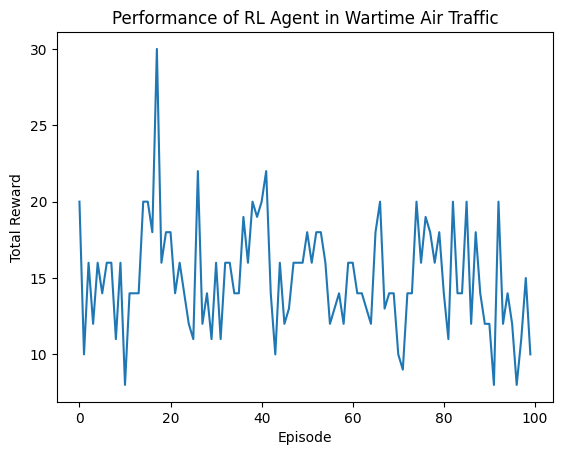

In [ ]:
import matplotlib.pyplot as plt

plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Performance of RL Agent in Wartime Air Traffic")
plt.show()

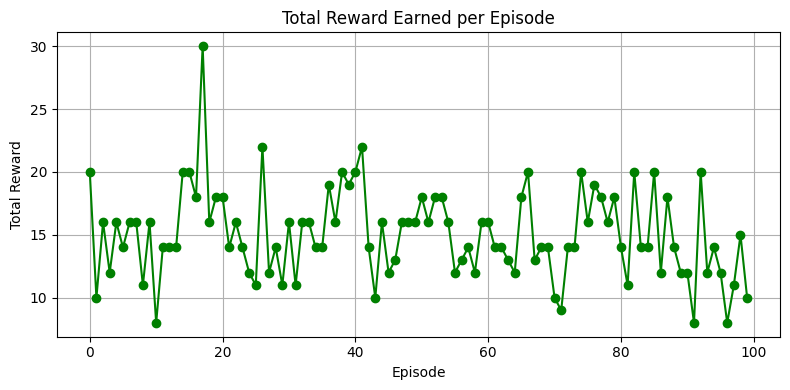

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(episode_rewards, marker='o', color='green')
plt.title("Total Reward Earned per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

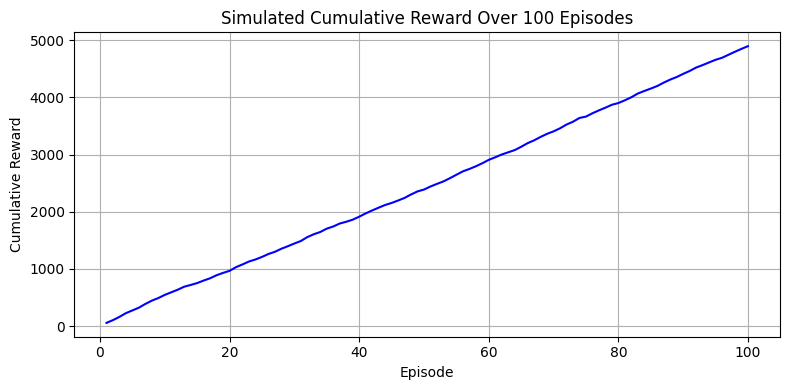

In [ ]:
cumulative_rewards = np.cumsum(rewards)
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, episodes + 1), cumulative_rewards, color='blue')
plt.title("Simulated Cumulative Reward Over 100 Episodes")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

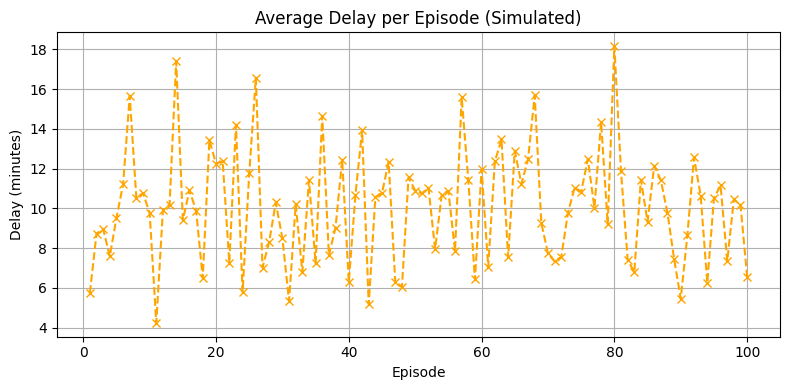

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, episodes + 1), avg_delays, color='orange', linestyle='--', marker='x')
plt.title("Average Delay per Episode (Simulated)")
plt.xlabel("Episode")
plt.ylabel("Delay (minutes)")
plt.grid(True)
plt.tight_layout()
plt.show()

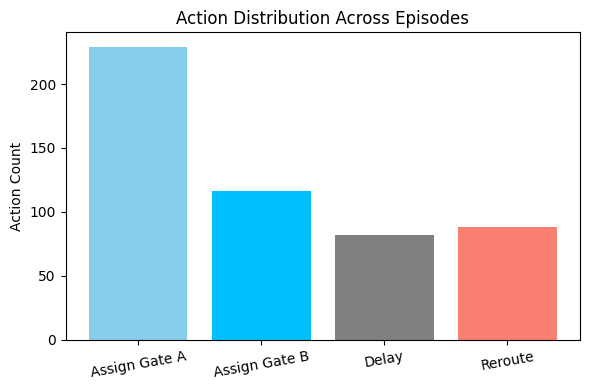

In [ ]:
plt.figure(figsize=(6, 4))
plt.bar(action_counts.keys(), action_counts.values(), color=['skyblue', 'deepskyblue', 'gray', 'salmon'])
plt.title("Action Distribution Across Episodes")
plt.ylabel("Action Count")
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()